# CrowdQC+ hands-on

Welcome to this hands-on on crowdsourced data from Citizen Weather Stations (CWS).

We have compiled a data set of CWS data for a certain region and a specific time to illustrate some issues with crowdsourced CWS data of air-temperature.

The goal is to apply the quality control (QC) package [CrowdQC+](https://github.com/dafenner/CrowdQCplus) to this data set to remove faulty values from it.

The corresponding scientific paper [Fenner et al. 2021](https://doi.org/10.3389/fenvs.2021.720747) was published in the open-access journal Frontiers in Environmental Science.

This exercise has the aims to:

*   Explain how you can use R in this Python environment
*   Provide hands-on experience with real crowdsourced CWS data
*   Enable you to investigate issues with such data
*   Explain how you can use CrowdQC+ to quality-control such data
*   Do some first analyses with the quality-controlled data

During the exercise (in this notebook), we have defined some tasks for you, that you can/should work on. 

**Tasks for you are marked in bold, like this line here.**

Please let Jonas (Kittner) or Daniel (Fenner) know if something is not working or in case of any questions.

******
**Copyright information: The data you are using in this exercise is protected by copyright and may NOT be used elsewhere than this course!**
******

Have fun!
---

---

---


# Section 1: Preparing environment

## Load drive

In [ ]:
# First load your Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# After mounting, check folders in left side-bar
# If this code does not work, you can use the "Mount Drive" button in the left side-bar

Mounted at /content/drive




---


## Start R session in Python environment
You can use the programming language [R](https://www.r-project.org/) is this Google Colab Python environment. All you need is the `rpy2.ipython` tool.

In [ ]:
%load_ext rpy2.ipython

Now, whenever you want R to be executed in a cell, add `%%R` at the beginning. Like so:

In [ ]:
%%R
x <- "Welcome to the BUCSS CrowdQC+ hands-on"
print(x)

[1] "Welcome to the BUCSS CrowdQC+ hands-on"


You can also transfer variables from the R environment to Python, like so:

In [ ]:
x = %R x
print(x)

[1] "Welcome to the BUCSS CrowdQC+ hands-on"



CrowdQC+ is written in R, so you will mainly use R in this hands-on.

At the end of the notebook and of this exercise you can play around with the data, either in R or in Python, whatever you prefer.

During some of the steps Google Colab gives (cryptic) warnings. Generally, you can ignore them (unless somethings is not working 😉).



---


## Set up directories

**Task: Change the name variable (`YOUR_NAME`) to your specific folder in the next block of code before running it so that your figures and output go to the right place. You can leave the rest as it is.**

In [ ]:
%%R

# Your own baseline directory - if mounted under MyDrive, do not change.
BASE_DIR = "/content/drive/MyDrive/BUCSS22/"
print(BASE_DIR)

# Create a link to notebooks directory
YOUR_NAME = "Daniel_Lecturer" # Name of your own folder, please adapt!
NOTEBOOKS_DIR = paste0(BASE_DIR, YOUR_NAME, "/", "notebooks/")
print(NOTEBOOKS_DIR)

# Other relevant folders
CWS_DIR        = paste0(BASE_DIR, "DATA_SHARE", "/", "CWS/")
OUT_DIR        = paste0(BASE_DIR, YOUR_NAME, "/", "output/")
FIG_DIR        = paste0(BASE_DIR, YOUR_NAME, "/", "figures/")
print(CWS_DIR)
print(OUT_DIR)
print(FIG_DIR)

[1] "/content/drive/MyDrive/BUCSS22/"
[1] "/content/drive/MyDrive/BUCSS22/Daniel_Lecturer/notebooks/"
[1] "/content/drive/MyDrive/BUCSS22/DATA_SHARE/CWS/"
[1] "/content/drive/MyDrive/BUCSS22/Daniel_Lecturer/output/"
[1] "/content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/"




---


## Install CrowdQC+ package (including dependencies, plus other packages)
This step might take 8-10 minutes (due to Google Colab, not the package 😀).

Several warnings might be thrown, don't worry.

In the meantime, why not checking out the [Github repo of CrowdQC+](https://github.com/dafenner/CrowdQCplus) or the [corresponding paper](https://www.frontiersin.org/articles/10.3389/fenvs.2021.720747/abstract) in another tab?!

In [ ]:
%%R
install.packages("ggmap")
devtools::install_github("dafenner/CrowdQCplus")

(as ‘lib’ is unspecified)

















































	‘/tmp/Rtmp3hqcDB/downloaded_packages’



(as ‘lib’ is unspecified)
































	‘/tmp/Rtmp3hqcDB/downloaded_packages’



* checking for file ‘/tmp/Rtmp3hqcDB/remotes374d724eeb/dafenner-CrowdQCplus-4f95e7b/DESCRIPTION’ ... OK
* preparing ‘CrowdQCplus’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘CrowdQCplus_1.0.1.tar.gz’



(as ‘lib’ is unspecified)



Puh, finally... nearly ready to work with the data...



---


## Load R libraries
Some warnings might be thrown, don't worry about them here either.

In [ ]:
%%R
library(lubridate)
library(data.table)
library(CrowdQCplus)
library(ggplot2)
library(ggmap)
library(scales)
library(sp)
library(raster)

Attaching package: ‘lubridate’



    date, intersect, setdiff, union



Attaching package: ‘data.table’



    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year






Check CrowdQC+ version. Should be 1.0.1 or higher.

In [ ]:
%%R
packageVersion("CrowdQCplus") 

[1] ‘1.0.1’




---


## Define a few generic functions for later
No need to go throught the code yourself (unless you are interested).

In [ ]:
%%R

# Get data at a certain QC level and retain only CWS with >= 1 valid data point
get_level_data_clean <- function(data, var = "ta", qc_level = "o3") {
  # make copy of data
  buff_data <- copy(data)
  
  # Input checks. var = "ta_int" only meaningful for QC levels o1-o4
  if(is.null(var)) ta_sel <- "ta_int" else ta_sel <- var
  if(qc_level %in% c("raw", "m0", "m1", "m2", "m3", "m4", "m5") & ta_sel == "ta_int") ta_sel <- "ta"
  
  # Set all entries of specified variable to NA at the specified QC level
  if(!(qc_level == "raw") & !(qc_level == "m0")) {
      buff_data <- buff_data[get(qc_level) == F, (var) := NA]
  }
  
  # Identify and keep all data for CWS with not all entries = NA
  not_all_na <- buff_data[, !(sum(is.na(get(var))) == .N), by = .(p_id)]
  buff_data <- buff_data[p_id %in% not_all_na[not_all_na$V1, p_id], ]
  
  return(buff_data)
}

# Time-series plot of all CWS as thin lines and median as thick orange
plot_time_series <- function(data, var = "ta", qc_level = "o3") {
    
  # check for "time"
  if("time" %in% colnames(data)) t <- "time" else t <- "date"

  plot_data <- get_level_data_clean(data, var = var, qc_level = qc_level)

  # calculate some statistics
  stats_cws <- plot_data[, .(mean = mean(get(var), na.rm = T),
                             median = median(get(var), na.rm = T), 
                             max  = max(get(var), na.rm = T), 
                             min  = min(get(var), na.rm = T)), keyby = t]

  # set up plot
  p <- ggplot(stats_cws, aes_string(x = t), na.rm = T) +
       labs(x = "time (UTC)", y = "ta (\u00B0C)", 
            title = paste0("QC level: ",qc_level,", N_CWS = ", length(unique(plot_data$p_id)))) +
       theme_bw() +
       coord_cartesian(ylim = c(-10, 65), expand = T) +
       scale_x_datetime(labels=date_format("%d-%m-%Y"), breaks = "1 day") +
       theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())

  # plot individual CWS and median
  p <- p + geom_line(data = plot_data, aes_string(x = t, y = var, group = "id"), na.rm = T, 
                       col = "black", alpha = 0.2, size = 0.1)
  p <- p + geom_line(data = stats_cws, aes_string(x = t, y = "median"), na.rm = T, 
                       col = "firebrick1", size = 0.6)

  # save image
  out_file <- paste0(FIG_DIR, "cws_time_series_",qc_level,".png")
  ggsave(filename = out_file, plot = p, 
         width = 25, height = 10, units = c("cm"), dpi = 300)
  print(paste0("Done! Image located here: ", out_file))
  return(p)
}



---


---
# Section 2: CWS data and preparation

## Read CWS data and prepare for CrowdQC+
Let's assume you have received the following file of CWS data from someone, you want to quality-control the data with the CrowdQC+ package, and then do some analyses.

First, read the CWS data and get a glimpse on the data.

**Task: Check the column names and think what they could mean.**

In [ ]:
%%R
data <- fread(paste0(CWS_DIR, "cws_data_cqcp_hands_on.csv"))
head(data)

                  date  p_id                id   ta max_temp min_temp humidity
1: 2019-07-19 01:00:00 49602 70:ee:50:2c:ea:ac 18.5     18.8     17.9       76
2: 2019-07-19 02:00:00 49602 70:ee:50:2c:ea:ac 17.0     17.5     16.8       88
3: 2019-07-19 03:00:00 49602 70:ee:50:2c:ea:ac 16.8     16.8     16.7       91
4: 2019-07-19 04:00:00 49602 70:ee:50:2c:ea:ac 16.6     16.7     16.6       91
5: 2019-07-19 05:00:00 49602 70:ee:50:2c:ea:ac 16.7     16.9     16.6       92
6: 2019-07-19 06:00:00 49602 70:ee:50:2c:ea:ac 17.4     17.8     17.0       92
   max_humidity min_humidity      lon      lat      alt lcz network
1:           82           73 6.910321 50.79552 85.72775   6 netatmo
2:           90           85 6.910321 50.79552 85.72775   6 netatmo
3:           91           90 6.910321 50.79552 85.72775   6 netatmo
4:           92           91 6.910321 50.79552 85.72775   6 netatmo
5:           92           92 6.910321 50.79552 85.72775   6 netatmo
6:           93           92 6.910321 5

For further processing we assign the correct time format to the `date` column and order the table by each CWS, identified via unique `p_id` and `date`.

In [ ]:
%%R
data <- data[, date := as.POSIXct(date, tz = "UTC")]
setkey(data, p_id, date)


**Task: Find out which geographical region the data cover. You can to this in Python or R, depending on your preference.**

Below is an example in R, carry it out in case you have no other idea. ;-)


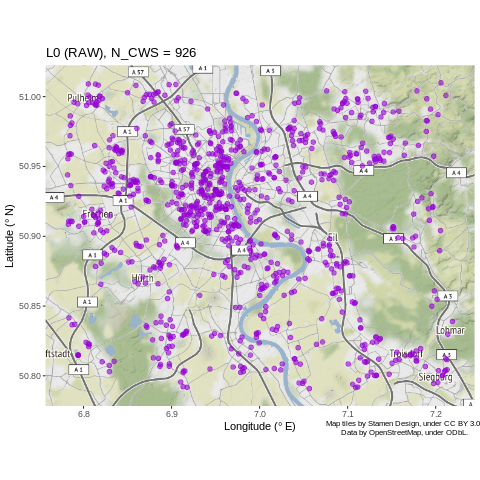

In [ ]:
%%R
# Get unique locations
cws_loc <- data[, .SD[1], .SDcols = c("lon", "lat", "lcz"), by = p_id]

# Background map
back_map <- get_map(location = c(min(cws_loc$lon-0.025, na.rm = T), min(cws_loc$lat-0.0125, na.rm = T), 
                                 max(cws_loc$lon+0.025, na.rm = T), max(cws_loc$lat+0.0125, na.rm = T)),
                    source = "stamen", maptype = "toner", force = FALSE, language = "en-EN")
# Plotting
m <- ggmap(back_map) +
  geom_point(data = cws_loc, mapping = aes(x = lon, y = lat), na.rm = T, 
             inherit.aes = FALSE, alpha = .6, size = 2, colour = "darkviolet") +
  labs(x = "Longitude (° E)", y = "Latitude (° N)", title = paste0("L0 (RAW), N_CWS = ", length(cws_loc$p_id)), 
       tag = "Map tiles by Stamen Design, under CC BY 3.0.\nData by OpenStreetMap, under ODbL.") +
  theme(plot.tag.position = c(0.85, 0.01), plot.tag = element_text(size = rel(0.7)))

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_locations_map.png"), plot = m, width = 21, height = 19, units = c("cm"), dpi = 300)
m

Ideas?



---

## Plot data and investigate problems with CWS air-temperature data
Let's look at the data set now, i.e., what time period it covers, how the air temperature was, etc.

[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_raw.png"


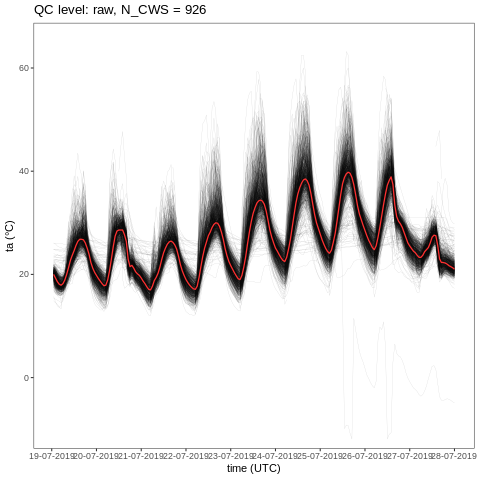

In [ ]:
%%R
# specify what to plot in the first section
# ++++++
plot_variable <- "ta"
qc_level      <- "raw"
# ++++++

# Now plotting
plot_time_series(data, var = plot_variable, qc_level = qc_level)

**Task: Investigate the time series plot.** *(You can also open the file with higher resolution in the respective folder. Exact location is given above the plot.)*

**Task: Identify typical errors or unusual things in the CWS time series of air temperature. You can note them down here:** *(double-click in this field to edit)*
- incomplete time series
- very high values (radiation error)
- indoor stations
- ...



---
Now you have identified typical errors and issues you find in crowdsourced CWS data of air temperature, you want to get rid of those before analysing.
Let's check whether the data table is in the correct format for CrowdQC+ and whether all requirements for the package are met with the function `cqcp_check_input`.

The functions carries out five main checks regarding 

1. presence and correct names of the data columns
2. sufficient length of time period
3. regularity of time series of each CWS
4. geographical extent of data not too large
5. suitable number of CWS for the QC

Warnings in red prevent the QC from execution, warnings in yellow give indications that something might not be ideal.


In [ ]:
%%R
ok <- cqcp_check_input(data)

+++++++++++++++++++++++++++++
+ CrowdQC+ input data check +
+++++++++++++++++++++++++++++
Check 1a - Required columns:
     ! Missing: time
     --> CrowdQC+ will not work with this data.
Check 1b - Optional columns:
     ! Missing: z
      --> Filters cqcp_m2 and cqcp_m5 will not work with 'heightCorrection = T'. You can run 'cqcp_add_dem_height' to add DEM information.
Check 2 - Temporal coverage:
     ! Columns needed for this check: 'p_id', 'time'. See Check 1a what is missing.
Check 3 - Regularity:
     ! Columns needed for this check: 'p_id', 'time'. See Check 1a what is missing.
Check 4 - Geographical extent:
     OK
Check 5 - Number of stations:
     ! Columns needed for this check: 'time', 'ta'.
     --> See Check 1a what is missing.


Seems that something is not correct with the data. We are apparently missing a required data column.

**Task: Find out which column is missing, check how the problem can be resolved, and resolve it.**

*Hint: Renaming columns can easily be done with* `setnames(data, old = "XYZ", new = "ABC")`

In [ ]:
%%R
setnames(data, old = "date", new = "time")
setnames(data, old = "alt", new = "z")

Now, let's check again:

In [ ]:
%%R
ok <- cqcp_check_input(data)

+++++++++++++++++++++++++++++
+ CrowdQC+ input data check +
+++++++++++++++++++++++++++++
Check 1a - Required columns:
     OK
Check 1b - Optional columns:
     OK
Check 2 - Temporal coverage:
     OK
Check 3 - Regularity:
     OK
Check 4 - Geographical extent:
     OK
Check 5 - Number of stations:
     OK


You can also add information on the elevation of each station with the package. This is useful for some of the QC levels, to account for elevation differences and make air-temperature data more comparable.

You can let CrowdQC+ automatically download DEM data (Digital Elevation Model) from the web, or you can give a Geotiff or R Raster Layer object with DEM information. This is handled by `cqcp_add_dem_height`.

In our case, we actually have the information already, we just need to name the column correctly. But maybe you have spotted that already?!

**Task: Rename the column with elevation information as required by CrowdQC+.**

In [ ]:
%%R
setnames(data, old = "ABC", new = "XYZ")

Check again:

In [ ]:
%%R
ok <- cqcp_check_input(data)

Looks like everything is in order now.


---


---
# Section 3: CrowdQC+
## Application of CrowdQC+

Let's carry out CrowdQC+. CrowdQC+ consists of five main QC levels m1-m5 and four optional QC levels o1-o4.

Each QC level addresses specific issues in the data.

During each QC level, an additional column is added to the data table. The new column is named as the QC level and contains only TRUE and FALSE flag values:

*   TRUE = value in row passed this QC level
*   FALSE = value in row did not pass this QC level

In subsequent QC levels only those values are considered that were flagged as TRUE in the previous level.

---

### QC level m1
This level addresses those CWS, that have identical geographical coordinates. This is common for Netatmo CWS and might be less of a problem with other types of CWS.

Netatmo CWS automatically receive a geographical position as soon as they are online, based on the IP address. In case the user doesn't set a proper location, that location is kept.

In [ ]:
%%R
# make a copy of the data, just to keep the original
data_qc <- copy(data)

# QC level m1
data_qc <- cqcp_m1(data_qc, cutOff = 1) # parameter 'cutOff' specifies how many CWS can have identical lat/lon values.

You can investigate the effect of the QC level on data availability:

In [ ]:
%%R
ok <- cqcp_output_statistics(data_qc)

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations


You can see that quite a few CWS had identical locations.

You can also plot the data, again as time series:

[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m1.png"


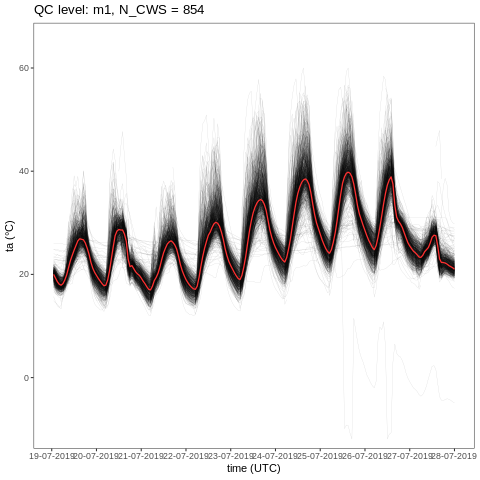

In [ ]:
%%R
# Specify what to plot in the first section
# ++++++
plot_variable <- "ta"
qc_level      <- "m1"
# ++++++

# Now plotting
plot_time_series(data_qc, var = plot_variable, qc_level = qc_level)

### QC level m2

This is the main QC level.

Here, it is assumed that at each point in time the data is a distribution of individual values. It is assumed that the (large) crowd of CWS contains useful data and all values that deviate too much from the majority of CWS are flagged as FALSE. Hence, the more CWS you have, the more robust this QC level is ("wisdom of the crowd").

The thresholds for the cutoff values are specified by the parameters `low` and `high`.

In this level, all data are first converted to a reference height so that air-temperature values are comparable.

For information on all parameters you can use the help with `?cqcp_m2`

In [ ]:
%%R
?cqcp_m2

File: /tmp/Rtmp3hqcDB/Rtxt3721bcacef
cqcp_m2              package:CrowdQCplus               R Documentation



_M_a_i_n _Q_C _s_t_e_p _m_2



_D_e_s_c_r_i_p_t_i_o_n:



     Flags all values as FALSE if robust z-score is not within the

     critical values obtained from low and high. This approach is based

     on the distribution function of all values. If number of stations

     is < 100 it would be better to use the Student-t distribution

     (t_distribution = TRUE).



_U_s_a_g_e:



     cqcp_m2(

       data,

       low = 0.01,

       high = 0.95,

       heightCorrection = TRUE,

       debug = FALSE,

       lapse_rate = 0.0065,

       t_distribution = FALSE,

       quiet = FALSE

     )

     

_A_r_g_u_m_e_n_t_s:



    data: data.table object as returned by cqcp_m1



     low: 0 < low < high < 1



    high: 0 < low < high < 1



heightCorrection: If set to true (default) and the column "z" exists in

          the input data, t

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m2.png"


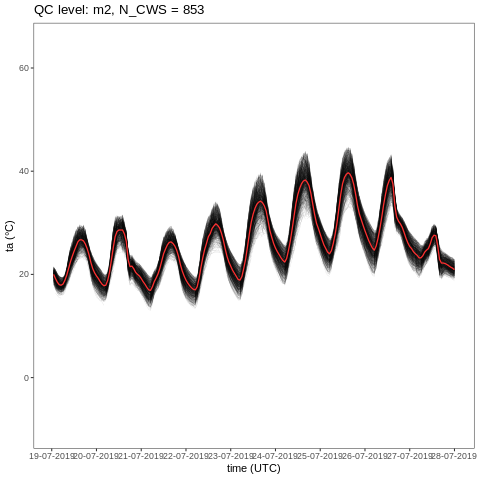

In [ ]:
%%R
# QC level m2
data_qc <- cqcp_m2(data_qc, low = 0.01, high = 0.95, heightCorrection = TRUE, 
                   lapse_rate = 0.0065, t_distribution = FALSE)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta", qc_level = "m2")

You can play around with the parameters in `cqcp_m2` in the code section below and re-run it. Then investigate the effect of the QC level on data availability and the actual data.

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m2.png"


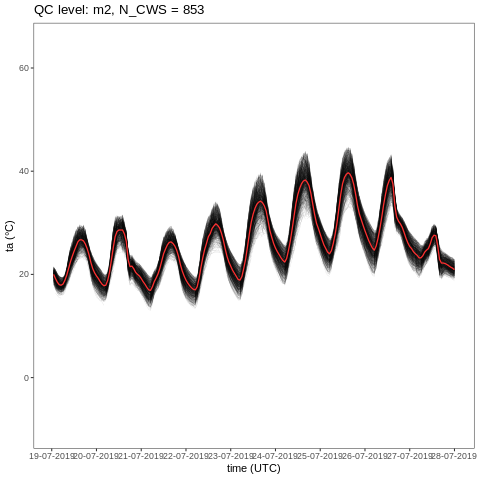

In [ ]:
%%R
# QC level m2
data_qc <- cqcp_m2(data_qc, low = 0.01, high = 0.95, heightCorrection = TRUE, 
                   lapse_rate = 0.0065, t_distribution = FALSE)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta", qc_level = "m2")

---
### QC level m3

This QC level flags all CWS that are too suspicious to be kept, i.e., it flags those CWS that received too many FALSE flags in QC level m2.

The check is done on a monthly basis per default, but could be set to any specified duration (parameter `duration`). Alternatively, you can use the complete time series, as in our case here:

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m3.png"


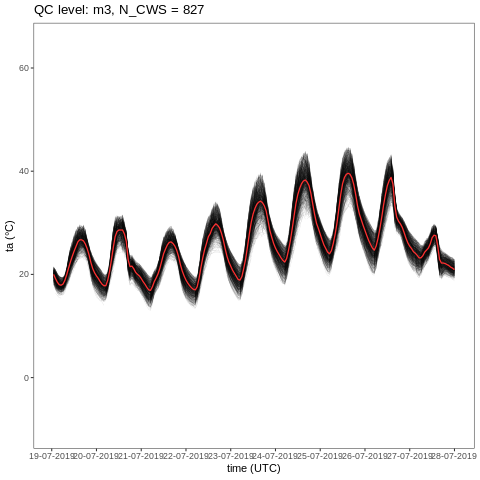

In [ ]:
%%R
# QC level m3
data_qc <- cqcp_m3(data_qc, cutOff = 0.2, complete = TRUE, duration = NULL)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta", qc_level = "m3")

Notice that overall data availability has not dropped a lot but quite a few stations were removed.

---
### QC level m4

QC level m4 mainly addresses CWS that were set up indoors, a common issue with Netatmo CWS. Those stations have a distinctly different evolution of air temperature compared to CWS located outdoors.

A temporal correlation is carried out to separate those CWS deviating too much from the median of all CWS. This should be done for the same time span as used in QC level m3.

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
QC level m4: 156171 values (= 82.46 % of raw data), 808 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m4.png"


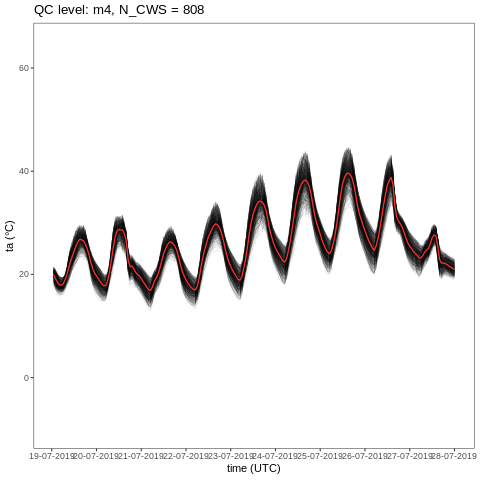

In [ ]:
%%R
# QC level m4
data_qc <- cqcp_m4(data_qc, cutOff = 0.9, complete = TRUE, duration = NULL)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta", qc_level = "m4")

---
### QC level m5

This QC level is a spatial buddy check and flags all values that are too different compared to spatially neighbouring stations, called "buddies" (spatial outlier filter). The idea is that again a larger group of CWS within a geographical region (here, a radius around each CWS) contains the "true" signal and CWS that deviate too much from that are flagged.

A minimum number of buddies within the specified radius around each CWS has to be present for the calculations, thus this QC level also flags isolated stations. 

In addition to flag variable `m5` another column `isolated` is added to the data table with FALSE and TRUE, if stations have >="n_buddies" within "radius" or not, respectively.

For further reading on this level and to understand all parameters, please check the help with `?qcqc_m5`.


++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
QC level m4: 156171 values (= 82.46 % of raw data), 808 stations
QC level m5: 138349 values (= 73.05 % of raw data), 803 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m5.png"


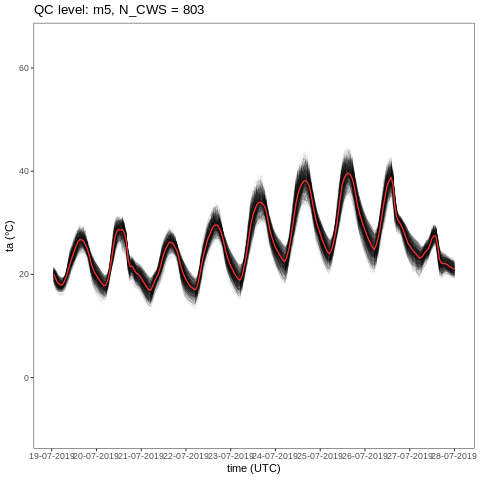

In [ ]:
%%R
# QC level m5
data_qc <- cqcp_m5(data_qc, radius = 3000, n_buddies = 5, alpha = 0.1, 
                   heightCorrection = TRUE, lapse_rate = 0.0065,
                   check_elevation = TRUE, max_elev_diff = 100,
                   keep_isolated = FALSE)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta", qc_level = "m5")

Again, you can modify the parameters in `cqcp_m5` in the code section below and re-run it. Then investigate the effect of the QC level on data availability and the actual data.

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
QC level m4: 156171 values (= 82.46 % of raw data), 808 stations
QC level m5: 139129 values (= 73.46 % of raw data), 807 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_m5.png"


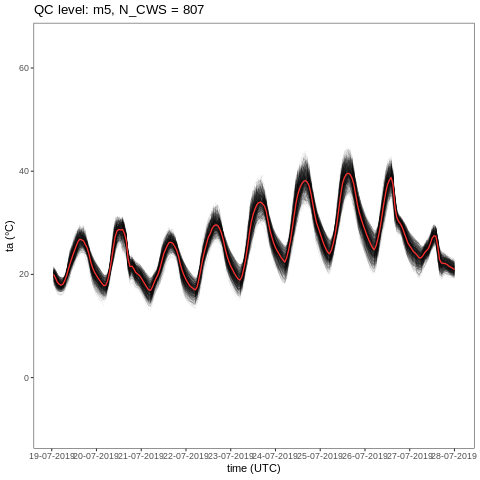

In [ ]:
%%R
# QC level m5
data_qc <- cqcp_m5(data_qc, radius = 3000, n_buddies = 5, alpha = 0.1, 
                   heightCorrection = TRUE, lapse_rate = 0.0065,
                   check_elevation = TRUE, max_elev_diff = 100,
                   keep_isolated = TRUE)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta", qc_level = "m5")

---
### QC level o1

This is the first optional QC level and does not remove/flag any values. It is a temporal interpolation to increase data availability. Per default, only gaps of one missing value are interpolated per CWS (could be changed).

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
QC level m4: 156171 values (= 82.46 % of raw data), 808 stations
QC level m5: 139129 values (= 73.46 % of raw data), 807 stations
QC level o1: 141170 values (= 74.54 % of raw data), 807 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_o1.png"


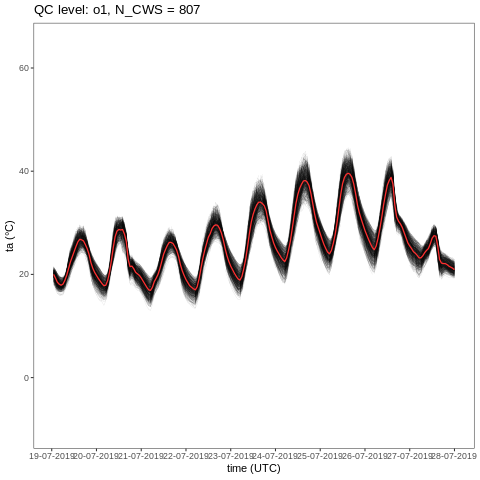

In [ ]:
%%R
# QC level o1
data_qc <- cqcp_o1(data_qc)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta_int", qc_level = "o1")

You can notice that data availability increased due to the temporal interpolation.

---
### QC level o2
This QC level checks for data availability per CWS per calendar day and flags all values per CWS and calendar day as FALSE if too many missing values are present (default: 80 % of valid data must be present).

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
QC level m4: 156171 values (= 82.46 % of raw data), 808 stations
QC level m5: 139129 values (= 73.46 % of raw data), 807 stations
QC level o1: 141170 values (= 74.54 % of raw data), 807 stations
QC level o2: 101176 values (= 53.42 % of raw data), 780 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_o2.png"


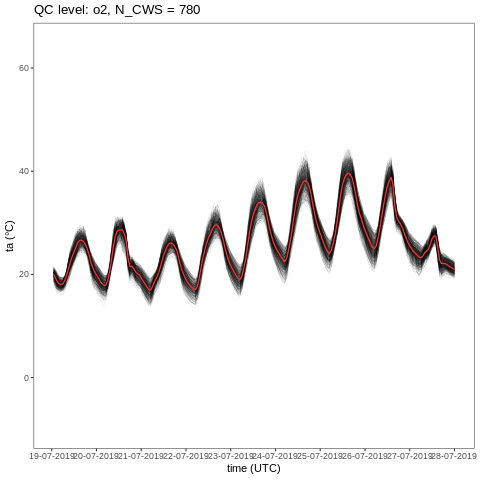

In [ ]:
%%R
# QC level o2
data_qc <- cqcp_o2(data_qc, cutOff = 0.8)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta_int", qc_level = "o2")

---
### QC level o3

As for QC level o2, this level checks for data availability. This time, the check is carried out per month or for the specified duration (as in m3 and m4).

++++++++++++++++++++++++++++++
+ CrowdQC+ output statistics +
++++++++++++++++++++++++++++++
Raw data: 189387 values, 926 stations
QC level m1: 174419 values (= 92.10 % of raw data), 854 stations
QC level m2: 158541 values (= 83.71 % of raw data), 853 stations
QC level m3: 157918 values (= 83.38 % of raw data), 827 stations
QC level m4: 156171 values (= 82.46 % of raw data), 808 stations
QC level m5: 139129 values (= 73.46 % of raw data), 807 stations
QC level o1: 141170 values (= 74.54 % of raw data), 807 stations
QC level o2: 101176 values (= 53.42 % of raw data), 780 stations
QC level o3: 59798 values (= 31.57 % of raw data), 294 stations
[1] "Done! Image located here: /content/drive/MyDrive/BUCSS22/Daniel_Lecturer/figures/cws_time_series_o3.png"


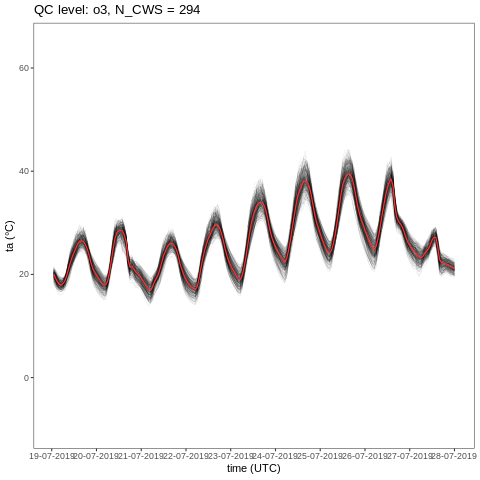

In [ ]:
%%R
# QC level o3
data_qc <- cqcp_o3(data_qc, cutOff = 0.8, complete = TRUE, duration = NULL)

# Statistics
ok <- cqcp_output_statistics(data_qc)

# Plotting
plot_time_series(data_qc, var = "ta_int", qc_level = "o3")

You can notice the drop in data availability after QC levels o2 and o3. Per default, those levels are quite strict and not always relevant. This depends on the application of CWS data. 

---
### QC level o4

QC level o4 implements a temporal data correction that could be necessary for sensors with a slow thermal response time. All data are corrected for a known time constant of the sensor. 

As this correction is applied to all CWS, the time constant must also be the same for all CWS in the data set. For Netatmo CWS, this is the case.

The correction is applied to the original data and a new column is added (`ta_corr`). No further column with flag values is added.

We will use the time constant published by [Coney et al. 2022](https://doi.org/10.1002/met.2075): 12.7 minutes = 762 seconds

Such a temporal correction is less relevant if you deal with hourly data (as in this example). For higher resolution analyses with, e.g., 5-minute data, it is of higher relevance.

In [ ]:
%%R
# QC level o4
data_qc <- cqcp_o4(data_qc, 762)

---
If you wanted the whole QC carried out at once, you could also do this:

In [ ]:
%%R
data_qc <- cqcp_qcCWS(data, complete = TRUE)

Let's save the quality-controlled data:

In [ ]:
%%R
fwrite(data_qc, file = paste0(OUT_DIR, "cws_data_cqcp_hands_on_QC.csv"), sep = ",")



---
## Output statistics and plotting

The following two blocks of code are the same as above, for investigating some basic statistics and for plotting. You can use them in case you want to investigate and/or plot again.

In [ ]:
%%R
ok <- cqcp_output_statistics(data_qc)

In [ ]:
%%R
# Specify what to plot in the first section
# ++++++
plot_variable <- "ta_int" # "ta" or "ta_int" ("ta_int" is only available after QC levels o1, o2, o3)
qc_level      <- "o1" # any one from: "raw", "m1", "m2", "m3", "m4", "m5", "o1", "o2", "o3"
# ++++++

# Now plotting
plot_time_series(data_qc, var = plot_variable, qc_level = qc_level)

---
---
# Section 4: Application

The following section contains several examples what you could do with the data.

You can follow along or explore the quality-controlled data set by yourself. For that, you can use R or Python, whatever you prefer.

---
## LCZ-based analyses

In [ ]:
%%R
# Get the quality-controlled data at level o1 for further analyses. Choose whichever level you want.
data_cws <- get_level_data_clean(data_qc, var = "ta_int", qc_level = "o1")

Load a [Local Climate Zone](https://doi.org/10.1175/BAMS-D-11-00019.1) (LCZ) map.
The map is part of the global LCZ map by [Demuzere et al. 2022](https://doi.org/10.5194/essd-14-3835-2022).

In [ ]:
%%R
# load LCZ for background
f_lcz <- paste0(BASE_DIR, "DATA_SHARE/WRF/INPUT/global_lcz_filter_v1_ruhrarea.tif")
lcz_map <- raster(f_lcz)

# crop to relevant extent
xlim <- c(min(data_cws$lon-0.1, na.rm = T), max(data_cws$lon+0.1, na.rm = T))
ylim <- c(min(data_cws$lat-0.1, na.rm = T), max(data_cws$lat+0.1, na.rm = T))

# crop
ext <- as(extent(xlim[1], xlim[2], ylim[1], ylim[2]), 'SpatialPolygons')
crs(ext) <- "+proj=longlat +datum=WGS84 +no_defs"
lcz_map <- crop(lcz_map, ext)

Plot all CWS on a LCZ map

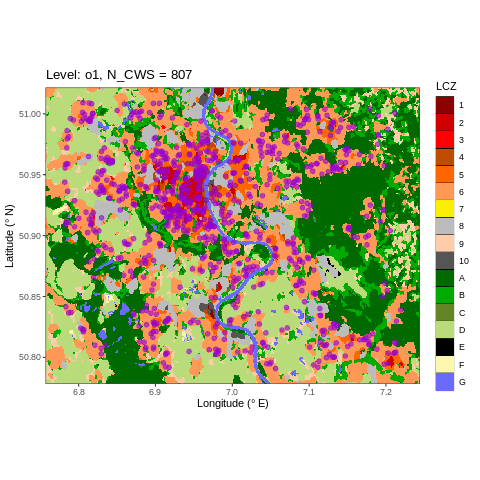

In [ ]:
%%R
# Get unique locations
cws_loc <- data_cws[, .SD[1], .SDcols = c("lon", "lat", "z", "lcz"), by = p_id]

# ggmap preparation
r_points = rasterToPoints(lcz_map)
r_dt = data.table(r_points)
setnames(r_dt, old = paste0("global_lcz_filter_v1_ruhrarea"), new = "lcz")
r_dt <- r_dt[lcz > 0]

# colours and names for map 
lcz_colors <- c("1" = "#8C0000", "2" = "#D10000", "3" = "#FF0000", "4" = "#BF4D00", 
                "5" = "#FF6600", "6" = "#FF9955", "7" = "#FAEE05", "8" = "#BCBCBC",
                "9" = "#FFCCAA", "10" = "#555555",
                "11" = "#006A00", "12" = "#00AA00", "13" = "#648525", "14" = "#B9DB79",
                "15" = "#000000", "16" = "#FBF7AE", "17" = "#6A6AFF")
    
lcz_names = c("1" = "1", "2" = "2", "3" = "3", "4" = "4", "5" = "5", 
              "6" = "6", "7" = "7", "8" = "8","9" = "9", "10" = "10",
              "11" = "A", "12" = "B", "13" = "C", "14" = "D",
              "15" = "E", "16" = "F", "17" = "G")
  
# plot limits
xlim <- c(min(cws_loc$lon-0.025, na.rm = T), max(cws_loc$lon+0.025, na.rm = T))
ylim <- c(min(cws_loc$lat-0.0125, na.rm = T), max(cws_loc$lat+0.0125, na.rm = T))
  
# plot
p <- ggplot() + geom_raster(data=r_dt, aes(x = x, y = y, fill = factor(lcz))) +
    theme_bw() +
    geom_point(data = cws_loc, aes(x = lon, y = lat), inherit.aes = FALSE, 
               alpha = .6, size = 2, colour = "darkviolet") +
    coord_quickmap(xlim = xlim, ylim = ylim, expand = F) +
    theme(panel.grid.major = element_blank(), legend.key = element_rect(color = "black")) +
    labs(x = "Longitude (\u00B0 E)", y = "Latitude (\u00B0 N)", 
         title = paste0("Level: o1, N_CWS = ", length(cws_loc$p_id)))
  
p <- p + scale_fill_manual(values = lcz_colors, name = "LCZ", labels = lcz_names)

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_locations_map_lcz_o1.png"), plot = p, width = 21, 
       height = 17, units = c("cm"), dpi = 300)
p

You can also investigate the distribution of CWS among LCZ. Above each bar the number of CWS and the respective percentage is shown.

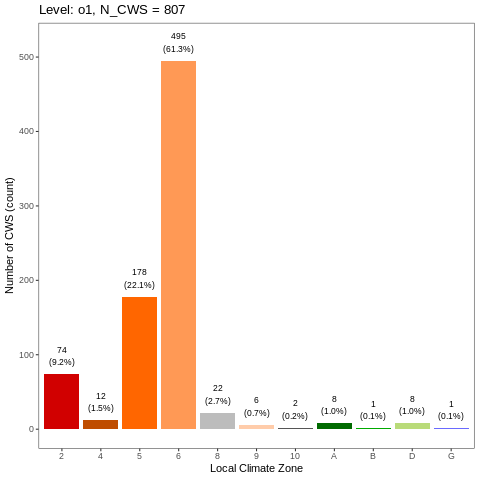

In [ ]:
%%R
pct_format = scales::percent_format(accuracy = .1)
# Plotting
p <- ggplot(cws_loc, aes(x = factor(lcz), fill = factor(lcz))) + 
     geom_bar(stat = "count") +
     labs(x = "Local Climate Zone", y = "Number of CWS (count)", 
         title = paste0("Level: o1, N_CWS = ", length(cws_loc$p_id))) +
     theme_bw() +
     scale_x_discrete(labels = lcz_names) +
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
           legend.position = "none") +
     coord_cartesian(ylim = c(0, 520), expand = T) +
     scale_fill_manual(values = lcz_colors) +
     geom_text(aes(label = sprintf("%d\n(%s)", ..count.., pct_format( ..count.. / sum(..count..)))), 
               stat = "count", colour = "black", size = 3, vjust=-0.5)

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_distribution_per_lcz_o1.png"), plot = p, width = 21, 
       height = 15, units = c("cm"), dpi = 300)
p

You can notice that the vast majority of the (quality-controlled) CWS are located in built environments. This is somewhat expected, since CWS are located where people live.

**Task: What is the number and percentage of CWS among 'built' and 'natural' LCZ?**

One possible solution:

In [ ]:
%%R
# add new column to the data.table, maybe useful for later
data_cws <- data_cws[lcz <= 10, lcz_type := "built"] # all built LCZ
data_cws <- data_cws[lcz >= 11, lcz_type := "natural"] # all natural LCZ

cws_loc <- data_cws[, .SD[1], .SDcols = c("lon", "lat", "z", "lcz", "lcz_type"), by = p_id]
cws_loc[, .(count = .N, percentage = (.N/length(cws_loc$p_id)*100)), by = lcz_type]

   lcz_type count percentage
1:    built   789  97.769517
2:  natural    18   2.230483


Plot median air-temperature over built and natural LCZ as time series

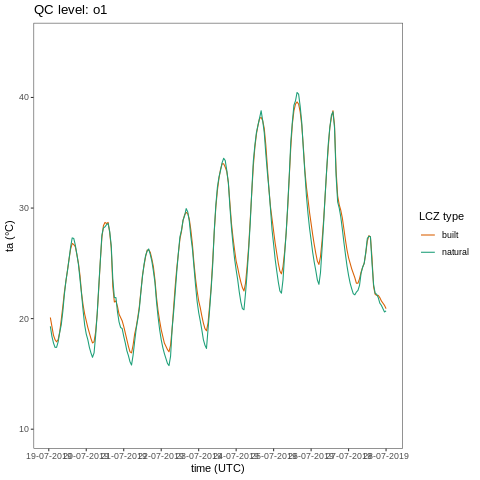

In [ ]:
%%R
# Aggregation
summary <- data_cws[, .(median = median(ta_int, na.rm = T)), keyby = c("time", "lcz_type")]

# Plotting
p <- ggplot(summary, aes(x = time, y = median, group = lcz_type), na.rm = T) +
     geom_line(aes(color=lcz_type)) +
     labs(x = "time (UTC)", y = "ta (\u00B0C)", title = paste0("QC level: o1"), color = "LCZ type") +
     theme_bw() +
     coord_cartesian(ylim = c(10, 45), expand = T) +
     scale_x_datetime(labels=date_format("%d-%m-%Y"), breaks = "1 day") +
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
     scale_color_manual(values=c("#d95f02", "#1b9e77"))

ggsave(filename = paste0(FIG_DIR, "cws_time_series_per_lcz_type_o1.png"), plot = p, width = 21, 
       height = 11, units = c("cm"), dpi = 300)
p

You could also plot the average diurnal cycle per LCZ type over the period:

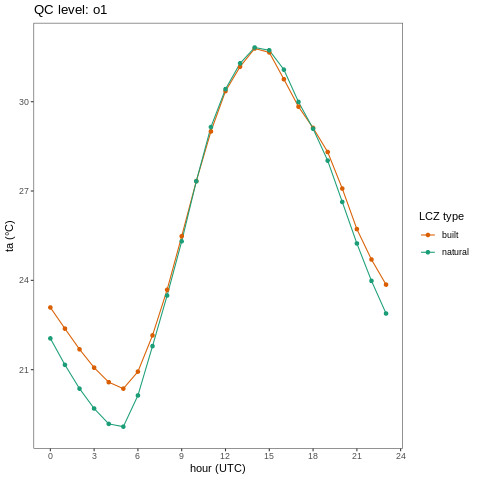

In [ ]:
%%R
# Calculate statistics
summary <- summary[, hour := hour(time)]
average_diurnal <- summary[, .(mean = mean(median, na.rm = T)), keyby = c("hour", "lcz_type")]

# Plotting
p <- ggplot(average_diurnal, aes(x = hour, y = mean, colour = lcz_type), na.rm = T) +
     geom_line() +
     geom_point() +
     labs(x = "hour (UTC)", y = "ta (\u00B0C)", title = paste0("QC level: o1"), color = "LCZ type") +
     theme_bw() +
     scale_x_continuous(breaks = seq(0,24,3)) +
     coord_cartesian(ylim = c(19, 32), expand = T) +     
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
     scale_color_manual(values=c("#d95f02", "#1b9e77"))

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_diurnal_cycle_per_lcz_type_o1.png"), plot = p, width = 16, 
       height = 12, units = c("cm"), dpi = 300)
p

**Task: Try to calculate and plot the average diurnal cycle of the air-temperature difference between the two LCZ types.**

One possible solution:

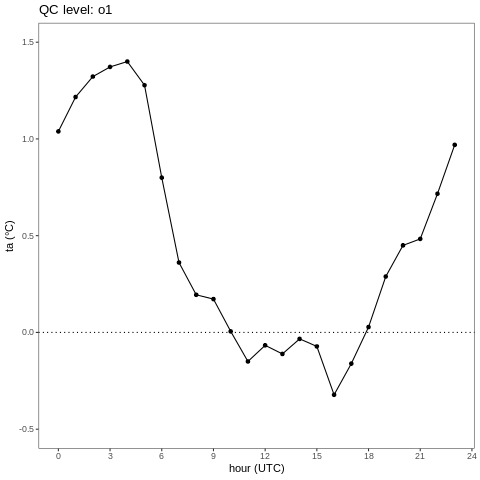

In [ ]:
%%R
diff <- as.data.table(average_diurnal[lcz_type == "built"]$mean - average_diurnal[lcz_type == "natural"]$mean)
diff <- diff[, hour := seq(0,23)]

# Plotting
p <- ggplot(diff, aes(x = hour, y = V1), na.rm = T) +
     geom_line() +
     geom_point() +
     labs(x = "hour (UTC)", y = "ta (\u00B0C)", title = paste0("QC level: o1")) +
     theme_bw() +
     scale_x_continuous(breaks = seq(0,24,3)) +
     coord_cartesian(ylim = c(-0.5, 1.5), expand = T) +     
     theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
     geom_hline(yintercept = 0, linetype = 3)

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_diurnal_cycle_diff_lcz_type_o1.png"), plot = p, width = 16, 
       height = 12, units = c("cm"), dpi = 300)
p

Nice, looks like the classical shape of the Urban Heat Island (UHI) in mid-latitude cities in summer.

We should check the elevation of the stations though. Not that all CWS in natural environments have a different elevation than the "urban" CWS:

In [ ]:
%%R
data_cws[, .(median_z = median(z, na.rm = T)), by = "lcz_type"]

   lcz_type median_z
1:    built 55.40704
2:  natural 61.49488


OK, doesn't look too bad overall.

Maybe we can now plot the air-temperature data on a map to see the spatial pattern of the UHI. We will average over all days for this.

**Task: Based on the average diurnal cycles above, select a suitable hour of the day for such a map.**

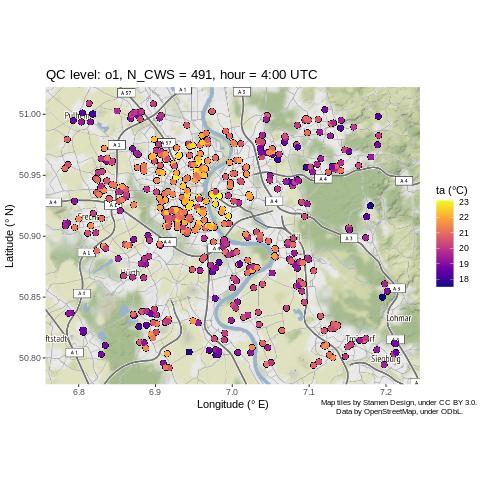

In [ ]:
%%R
# Specify hour (and colour limits, if you want same colour range across maps)
# ++++++
analysis_hour <- "4"
colour_limits <- NULL # e.g., colour_limits <- c(17,24)
# ++++++

# Get data for hour
data_cws <- data_cws[, hour := hour(time)]
data_map <- copy(data_cws)
data_map <- data_map[hour == analysis_hour]

# Average over days and remove NA values
data_map <- data_map[, ta_ave := mean(ta_int), by = "p_id"][, head(.SD, 1), .SDcols = c("lon", "lat", "ta_ave"), by = p_id]
data_map <- data_map[!is.na(ta_ave)]

# Plot the map
m <- ggmap(back_map) +
     geom_point(data = data_map, aes(x = lon, y = lat), shape = 16, size = 3) +
     geom_point(data = data_map, aes(x = lon, y = lat, color = ta_ave), shape = 16, size = 2.5) +
     scale_color_viridis_c(option = "plasma", name = "ta (\u00B0C)", limits = colour_limits) +
     labs(x = "Longitude (° E)", y = "Latitude (° N)", 
          title = paste0("QC level: o1, N_CWS = ", length(unique(data_map$p_id)), ", hour = ", analysis_hour, ":00 UTC"),
          tag = "Map tiles by Stamen Design, under CC BY 3.0.\nData by OpenStreetMap, under ODbL.") +
     theme(plot.tag.position = c(0.84, 0.01), plot.tag = element_text(size = rel(0.7))) 

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_air_temperature_map_h=",analysis_hour,".png"), plot = m, width = 21, 
       height = 17, units = c("cm"), dpi = 300)
m

You could also plot the deviation of each CWS to the spatial median across all CWS:



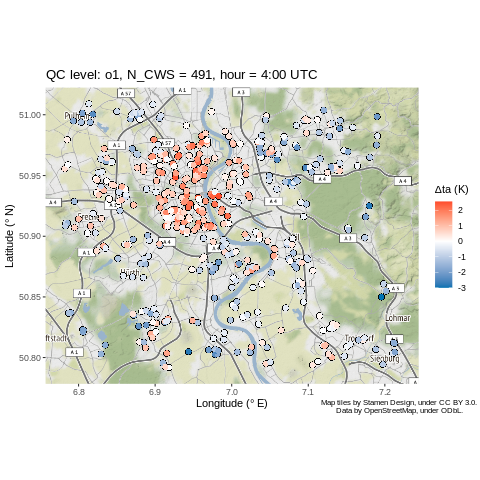

In [ ]:
%%R
# Specify hour (and colour limits, if you want same colour range across maps)
# ++++++
analysis_hour <- "4"
colour_limits <- NULL # e.g., colour_limits <- c(-3,3)
# ++++++

# Get data for hour
data_cws <- data_cws[, hour := hour(time)]
data_map <- copy(data_cws)
data_map <- data_map[hour == analysis_hour]

# Average over days and remove NA values
data_map <- data_map[, ta_ave := mean(ta_int), by = "p_id"][, head(.SD, 1), .SDcols = c("lon", "lat", "ta_ave"), by = p_id]
data_map <- data_map[!is.na(ta_ave)][, ta_diff := ta_ave - median(ta_ave)]

# Plot the map
m <- ggmap(back_map) +
     geom_point(data = data_map, aes(x = lon, y = lat), shape = 16, size = 3) +
     geom_point(data = data_map, aes(x = lon, y = lat, color = ta_diff), shape = 16, size = 2.5) +
     scale_color_gradient2(low = "#0072B2", high = "red", mid = "white", na.value = "grey", 
                           limits = colour_limits, name = expression(paste(Delta,"ta (K)"))) +
     labs(x = "Longitude (° E)", y = "Latitude (° N)", 
          title = paste0("QC level: o1, N_CWS = ", length(unique(data_map$p_id)), ", hour = ", analysis_hour, ":00 UTC"),
          tag = "Map tiles by Stamen Design, under CC BY 3.0.\nData by OpenStreetMap, under ODbL.") +
     theme(plot.tag.position = c(0.84, 0.01), plot.tag = element_text(size = rel(0.7))) 

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_air_temperature_difference_median_map_h=",analysis_hour,".png"), plot = m, width = 21, 
       height = 17, units = c("cm"), dpi = 300)
m

And finally, plot the air-temperature difference of each CWS to the mean of all CWS located in "natural" LCZ:

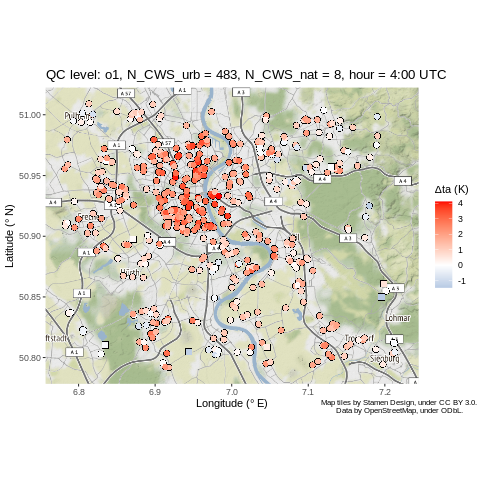

In [ ]:
%%R
# Specify hour (and colour limits, if you want same colour range across maps)
# ++++++
analysis_hour <- "4"
colour_limits <- NULL
# ++++++

# Get data for hour
data_cws <- data_cws[, hour := hour(time)]
data_map <- copy(data_cws)
data_map <- data_map[hour == analysis_hour]

# Average over days, select row and columns, remove NA
data_map <- data_map[, ta_ave := mean(ta_int), by = "p_id"][, head(.SD, 1), .SDcols = c("lon", "lat", "ta_ave", "lcz_type"), by = p_id][!is.na(ta_ave)]

# Calculate mean ta over all CWS in "natural" LCZ
mean_natural <- mean(data_map[lcz_type == "natural"]$ta_ave)

# Calculate difference
data_map <- data_map[, ta_diff := ta_ave - mean_natural]

data_map_urb <- data_map[lcz_type == "built"]
data_map_nat <- data_map[lcz_type == "natural"]

# Plot the map
m <- ggmap(back_map) +
     geom_point(data = data_map_urb, aes(x = lon, y = lat), shape = 16, size = 3) +
     geom_point(data = data_map_urb, aes(x = lon, y = lat, color = ta_diff), shape = 16, size = 2.5) +
     geom_point(data = data_map_nat, aes(x = lon, y = lat), shape = 15, size = 3) +
     geom_point(data = data_map_nat, aes(x = lon, y = lat, color = ta_diff), shape = 15, size = 2.5) +
     scale_color_gradient2(low = "#0072B2", high = "red", mid = "white", na.value = "grey", 
                           limits = colour_limits, name = expression(paste(Delta,"ta (K)"))) +
     labs(x = "Longitude (° E)", y = "Latitude (° N)", 
          title = paste0("QC level: o1, N_CWS_urb = ", length(unique(data_map_urb$p_id)),
                         ", N_CWS_nat = ", length(unique(data_map_nat$p_id)),", hour = ", analysis_hour, ":00 UTC"),
          tag = "Map tiles by Stamen Design, under CC BY 3.0.\nData by OpenStreetMap, under ODbL.") +
     theme(plot.tag.position = c(0.84, 0.01), plot.tag = element_text(size = rel(0.7))) 

# Saving
ggsave(filename = paste0(FIG_DIR, "cws_air_temperature_difference_naturalLCZ_map_h=",analysis_hour,".png"), plot = m, width = 21, 
       height = 17, units = c("cm"), dpi = 300)
m

##That's it for today, well done!

Feel free to play around with the data on your own now.

Do not hesitate to ask Jonas (Kittner) or Daniel (Fenner) if something is not working or in case of any questions.